[![nbviewer](https://raw.githubusercontent.com/jupyter/design/master/logos/Badges/nbviewer_badge.svg)](https://nbviewer.org/github/hamish-smeele/Portfolio/blob/main/Red_Snowfall.ipynb)

## Red Resort Snowfall Data Analysis

This project was completed to demonstrate core data analyst competencies, with a focus on data acquisition, data wrangling, and exploratory analysis. Raw JSON files sourced from the Red Resort website are ingested and transformed into a structured, analysis-ready dataset suitable for downstream analysis.

The analysis is implemented in Python using commonly adopted data science libraries, including NumPy, Pandas, Seaborn, and Matplotlib. Several example analytical objectives are explored to demonstrate the ability to create clear, informative visualizations that support data exploration and insight generation.

__Objectives:__
1. Determine which season has the highest snowfall and how this compares to average
2. Investigate highest average snowfall periods: (a) Two week period. (b) One week period.
3. Create a graph showing mean snowfall vs date (day in the year).
4. Create a graph showing each season plotted vs date (day in the year).
5. Plot bi-montly total snowfall (cm) vs ENSO MEI to determine whether there is any trend that can be observed.

### Objective 1: Determine which season has the highest snowfall and how this compares to average

In [91]:
# Import Required Libraries

import io
import json
import math
from calendar import monthrange
from datetime import timedelta
from pathlib import Path

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator, FuncFormatter
import numpy as np
import pandas as pd
import requests
import seaborn as sns


In [ ]:
# Set global plotting and display defaults for reproducibility
sns.set_theme(style="whitegrid", palette="crest")
plt.rcParams['figure.dpi'] = 120
pd.options.display.width = 120
pd.options.display.float_format = '{:,.2f}'.format


In [92]:
# Pull Red Resort JSON Files

BASE_URL = "https://api.redresort.com/report/history"
YEARS = range(2004, 2025)  # inclusive of 2024

session = requests.Session()


def fetch_year(year: int) -> pd.DataFrame:
    '''Download a single season from the Red Resort history API.'''
    url = f"{BASE_URL}?year={year}"
    response = session.get(url, timeout=15)
    response.raise_for_status()
    data = response.json()
    return pd.json_normalize(data).assign(year=year)


def fetch_all_years(years) -> pd.DataFrame:
    frames = []
    for y in years:
        try:
            frames.append(fetch_year(y))
        except Exception as exc:
            print(f"Failed for {y}: {exc}")
    combined = pd.concat(frames, ignore_index=True) if frames else pd.DataFrame()
    if combined.empty:
        raise ValueError("No data returned from the Red Resort API; rerun or verify connectivity.")
    return combined


df = fetch_all_years(YEARS)
print(f"Fetched {df.shape[0]:,} rows across {df['year'].nunique()} seasons")

# Persist a raw copy to aid reproducibility if the API changes
Path('data').mkdir(exist_ok=True)
df.to_json(Path('data') / 'red_resort_history.json', orient='records', indent=2)

df.head()


,WeatherData,RequestedYear,MountainReport.MRID,MountainReport.SkyB,MountainReport.SkyBText,MountainReport.SkyS,MountainReport.SkySText,MountainReport.MetricToday,MountainReport.MetricOvernight,MountainReport.Metric24hours,...,MountainReport.Notes,MountainReport.SummerMode,MountainReport.DateTime,MountainReport.MailingListID,MountainReport.UserID,MountainReport.Lifts,MountainReport.SnowData,MountainReport.HeaderImage,MountainReport.TotalSnowDepth,year
0,None,2004,0,0,,0,,0,0,0,...,,False,0001-01-01T00:00:00Z,0,0,None,"[{'Month': 'October', 'Year': 2004, 'Total': 4...",,487,2004
1,None,2005,0,0,,0,,0,0,0,...,,False,0001-01-01T00:00:00Z,0,0,None,"[{'Month': 'October', 'Year': 2005, 'Total': 2...",,781,2005
2,None,2006,0,0,,0,,0,0,0,...,,False,0001-01-01T00:00:00Z,0,0,None,"[{'Month': 'October', 'Year': 2006, 'Total': 0...",,434,2006
3,None,2007,0,0,,0,,0,0,0,...,,False,0001-01-01T00:00:00Z,0,0,None,"[{'Month': 'October', 'Year': 2007, 'Total': 0...",,577,2007
4,None,2008,0,0,,0,,0,0,0,...,,False,0001-01-01T00:00:00Z,0,0,None,"[{'Month': 'October', 'Year': 2008, 'Total': 0...",,469,2008


In [93]:
# Remove cols not required from Data Frame

# columns to keep
cols_keep = ["MountainReport.SnowData", "MountainReport.TotalSnowDepth", "year" ]

# select only those columns that exist; drops all others
df = df.loc[:, df.columns.intersection(cols_keep)]

# quick check
df.head()


,MountainReport.SnowData,MountainReport.TotalSnowDepth,year
0,"[{'Month': 'October', 'Year': 2004, 'Total': 4...",487,2004
1,"[{'Month': 'October', 'Year': 2005, 'Total': 2...",781,2005
2,"[{'Month': 'October', 'Year': 2006, 'Total': 0...",434,2006
3,"[{'Month': 'October', 'Year': 2007, 'Total': 0...",577,2007
4,"[{'Month': 'October', 'Year': 2008, 'Total': 0...",469,2008


In [94]:
### Split Data Frame into Season Totals and Daily Snowfall

# columns to keep
daily_cols_keep = ["MountainReport.SnowData"]

# select only those columns that exist; drops all others
df_daily = df.loc[:, df.columns.intersection(daily_cols_keep)]

# columns to keep
totals_cols_keep = ["MountainReport.TotalSnowDepth", "year" ]

# select only those columns that exist; drops all others
df_totals = df.loc[:, df.columns.intersection(totals_cols_keep)]

In [95]:
df_daily.head()

,MountainReport.SnowData
0,"[{'Month': 'October', 'Year': 2004, 'Total': 4..."
1,"[{'Month': 'October', 'Year': 2005, 'Total': 2..."
2,"[{'Month': 'October', 'Year': 2006, 'Total': 0..."
3,"[{'Month': 'October', 'Year': 2007, 'Total': 0..."
4,"[{'Month': 'October', 'Year': 2008, 'Total': 0..."


In [96]:
df_totals.head()

,MountainReport.TotalSnowDepth,year
0,487,2004
1,781,2005
2,434,2006
3,577,2007
4,469,2008


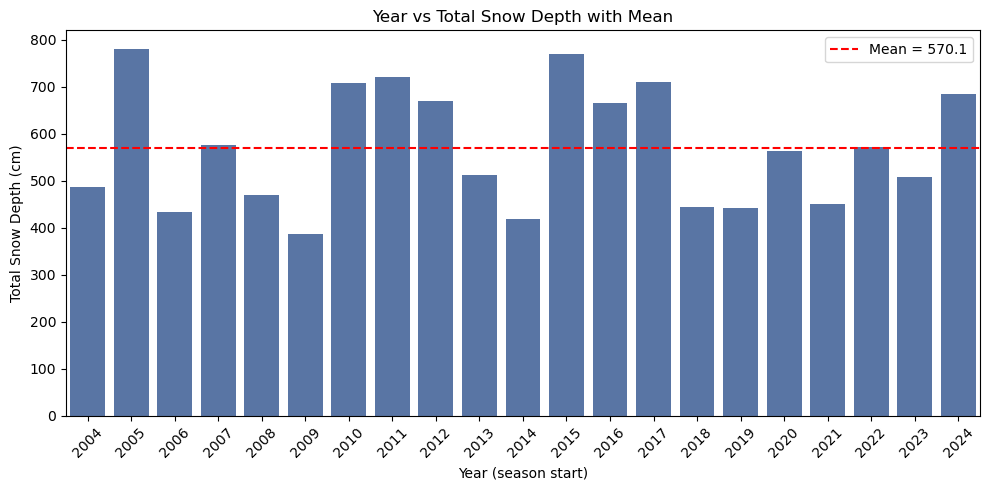

In [97]:
df_totals = df_totals[["year", "MountainReport.TotalSnowDepth"]].dropna()
mean_depth = df_totals["MountainReport.TotalSnowDepth"].mean()
best_season = df_totals.loc[df_totals["MountainReport.TotalSnowDepth"].idxmax()]

plt.figure(figsize=(10, 5))
ax = sns.barplot(
    data=df_totals,
    x="year",
    y="MountainReport.TotalSnowDepth",
    color=sns.color_palette()[0],
    edgecolor='black'
)
ax.axhline(mean_depth, color="#d62728", linestyle="--", linewidth=1.5, label=f"Mean = {mean_depth:.1f} cm")
ax.bar_label(ax.containers[0], fmt='%.0f', rotation=90, padding=2, fontsize=8)
plt.xlabel("Year (season start)")
plt.ylabel("Total Snow Depth (cm)")
plt.title("Year vs Total Snow Depth with Mean Benchmark")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

print(f"Highest recorded season: {int(best_season['year'])} with {best_season['MountainReport.TotalSnowDepth']:.1f} cm")


#### Objective 1 results
* Average total snowfall across seasons: the dashed red line.
* Highest recorded season is called out beneath the chart for quick reference.
* Values are printed on each bar to make year-over-year changes easy to read.


### Objective 2: Investigate highest snowfall periods

In [98]:
### Examine MountainReport.SnowData to work out how to organise and clean data

# Pick one element, e.g., the first non-null, to understand structure
sample = df_daily["MountainReport.SnowData"].dropna().iloc[0]

print(sample)
print(type(sample))


[{'Month': 'October', 'Year': 2004, 'Total': 45, 'DaysInMonth': 31, 'Ceiling': 40, 'Days': {'1': 0, '10': 0, '11': 0, '12': 0, '13': 0, '14': 0, '15': 0, '16': 0, '17': 0, '18': 0, '19': 0, '2': 0, '20': 0, '21': 0, '22': 40, '23': 0, '24': 0, '25': 5, '26': 0, '27': 0, '28': 0, '29': 0, '3': 0, '30': 0, '31': 0, '4': 0, '5': 0, '6': 0, '7': 0, '8': 0, '9': 0}, 'CurrentMonth': True}, {'Month': 'November', 'Year': 2004, 'Total': 75, 'DaysInMonth': 30, 'Ceiling': 35, 'Days': {'1': 8, '10': 0, '11': 0, '12': 0, '13': 0, '14': 0, '15': 0, '16': 0, '17': 0, '18': 10, '19': 3, '2': 14, '20': 0, '21': 0, '22': 0, '23': 0, '24': 9, '25': 13, '26': 13, '27': 0, '28': 0, '29': 0, '3': 0, '30': 5, '4': 0, '5': 0, '6': 0, '7': 0, '8': 0, '9': 0}, 'CurrentMonth': False}, {'Month': 'December', 'Year': 2004, 'Total': 162, 'DaysInMonth': 31, 'Ceiling': 36, 'Days': {'1': 0, '10': 0, '11': 0, '12': 0, '13': 3, '14': 2, '15': 0, '16': 0, '17': 0, '18': 0, '19': 2, '2': 0, '20': 2, '21': 0, '22': 0, '23':

In [99]:
def transform_snowfall(records):
    '''Explode a list of snowfall records so each day becomes its own column.'''
    df = pd.DataFrame(records)
    day_df = df.pop("Days").apply(pd.Series)
    day_df.columns = [f"day_{int(c)}" for c in day_df.columns]
    day_df = day_df.reindex(sorted(day_df.columns, key=lambda x: int(x.split("_")[1])), axis=1)
    return pd.concat([df, day_df], axis=1)

frames = []

for i, snow in df_daily["MountainReport.SnowData"].items():
    # Skip missing/empty entries
    if snow is None:
        continue
    if isinstance(snow, float) and math.isnan(snow):
        continue
    if isinstance(snow, (list, tuple, dict)) and len(snow) == 0:
        continue

    try:
        snow_df = transform_snowfall(snow)
        snow_df["source_row"] = i  # optional trace back to original row
        frames.append(snow_df)
    except Exception as exc:
        print(f"Skipped row {i}: {exc}")

pd_daily = pd.concat(frames, ignore_index=True) if frames else pd.DataFrame()

pd_daily.head(20)


,Month,Year,Total,DaysInMonth,Ceiling,CurrentMonth,day_1,day_2,day_3,day_4,...,day_23,day_24,day_25,day_26,day_27,day_28,day_29,day_30,day_31,source_row
0,October,2004,45,31,40,True,0.0,0.0,0.0,0.0,...,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,November,2004,75,30,35,False,8.0,14.0,0.0,0.0,...,0.0,9.0,13.0,13.0,0.0,0.0,0.0,5.0,NaN,0
2,December,2004,162,31,36,False,0.0,0.0,0.0,16.0,...,3.0,0.0,24.0,11.0,0.0,0.0,0.0,3.0,0.0,0
3,January,2005,80,31,35,False,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,4.0,0.0,2.0,0.0,0.0,0.0,0
4,February,2005,6,28,35,False,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.0,NaN,NaN,NaN,0
5,March,2005,90,31,35,False,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,20.0,30.0,30.0,10.0,0.0,0.0,0
6,April,2005,29,30,35,False,8.0,11.0,5.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0
7,October,2005,20,31,35,True,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.0,1
8,November,2005,196,30,35,False,10.0,10.0,18.0,0.0,...,0.0,0.0,16.0,20.0,0.0,0.0,12.0,7.0,NaN,1
9,December,2005,107,31,35,False,0.0,28.0,0.0,0.0,...,11.0,0.0,0.0,5.0,7.0,0.0,5.0,18.0,4.0,1


In [100]:
# Melt wide day_* columns to a tidy long format
long = pd_daily.melt(id_vars=["Year", "Month"], var_name="day_col", value_name="snow_cm")

# Extract day number safely
long["day"] = pd.to_numeric(long["day_col"].str.extract(r"(\d+)")[0], errors="coerce")
long = long.dropna(subset=["day"])
long = long[long["day"] % 1 == 0]
long["day"] = long["day"].astype(int)

# Month name -> number; if Month is already numeric, skip this line
long["month_num"] = pd.to_datetime(long["Month"], format="%B").dt.month
long["year_num"] = pd.to_numeric(long["Year"], errors="coerce")
long = long.dropna(subset=["month_num", "year_num"])

# Drop impossible dates
max_days = long.apply(lambda r: monthrange(int(r["year_num"]), int(r["month_num"]))[1], axis=1)
long = long[long["day"] <= max_days]

# Climatological mean per calendar day
climo = (
    long.groupby(["month_num", "day"], as_index=False)["snow_cm"]
        .mean()
        .rename(columns={"snow_cm": "mean_snow_cm"})
)

climo["date"] = pd.to_datetime(
    dict(year=2000, month=climo["month_num"].astype(int), day=climo["day"].astype(int))
)

series = climo.set_index("date").sort_index()["mean_snow_cm"]
rolling_total = series.rolling(window=14, min_periods=14).sum()
end_date = rolling_total.idxmax()
start_date = end_date - pd.Timedelta(days=13)

max_total = rolling_total.loc[end_date]
mean_per_day = max_total / 14

start_md = start_date.strftime("%b %d")
end_md   = end_date.strftime("%b %d")

print(f"Best 14-day window: {start_md} to {end_md}")
print(f"Avg total over window: {max_total:.2f} cm (mean {mean_per_day:.2f} cm/day)")


Best 14-day window: Dec 17 to Dec 30
Avg total over window: 71.71 cm (mean 5.12 cm/day)


In [101]:
# Repeat rolling calculation for a one-week window
rolling_total_7 = series.rolling(window=7, min_periods=7).sum()
end_date = rolling_total_7.idxmax()
start_date = end_date - pd.Timedelta(days=6)

max_total = rolling_total_7.loc[end_date]
mean_per_day = max_total / 7

print(f"Best 7-day window: {start_date:%b %d} to {end_date:%b %d}")
print(f"Avg total over window: {max_total:.2f} cm (mean {mean_per_day:.2f} cm/day)")


Best 7-day window: Dec 21 to Dec 27
Avg total over window: 39.33 cm (mean 5.62 cm/day)


**Rolling window takeaway:** The calculations above report the snowiest 14-day and 7-day windows based on the climatological daily means, helping trip planners target historically strong periods.


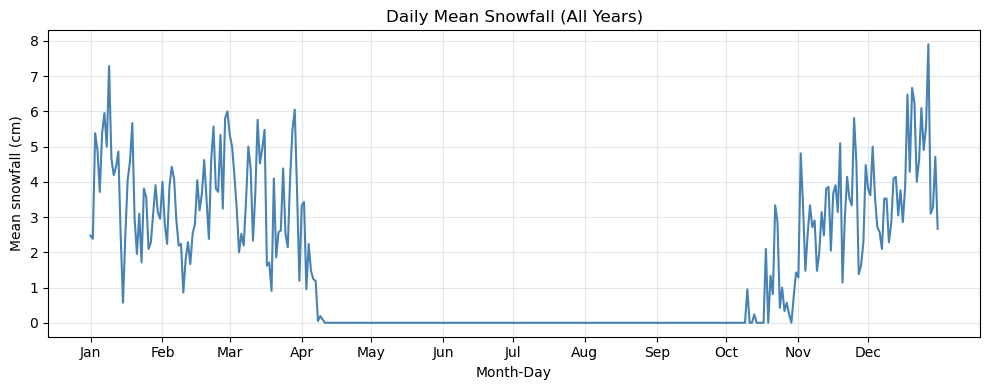

In [102]:
# Visualise the daily mean snowfall cycle
fig, ax = plt.subplots(figsize=(10, 4))
sns.lineplot(x=series.index, y=series.values, ax=ax, color="steelblue")

ax.set_title("Daily Mean Snowfall (All Years)")
ax.set_xlabel("Month-Day")
ax.set_ylabel("Mean snowfall (cm)")
ax.grid(True, alpha=0.3)

# Optional: cleaner month ticks
ax.set_xticks(series.resample("MS").mean().index)
ax.set_xticklabels(series.resample("MS").mean().index.strftime("%b"), rotation=0)
plt.tight_layout()
plt.show()


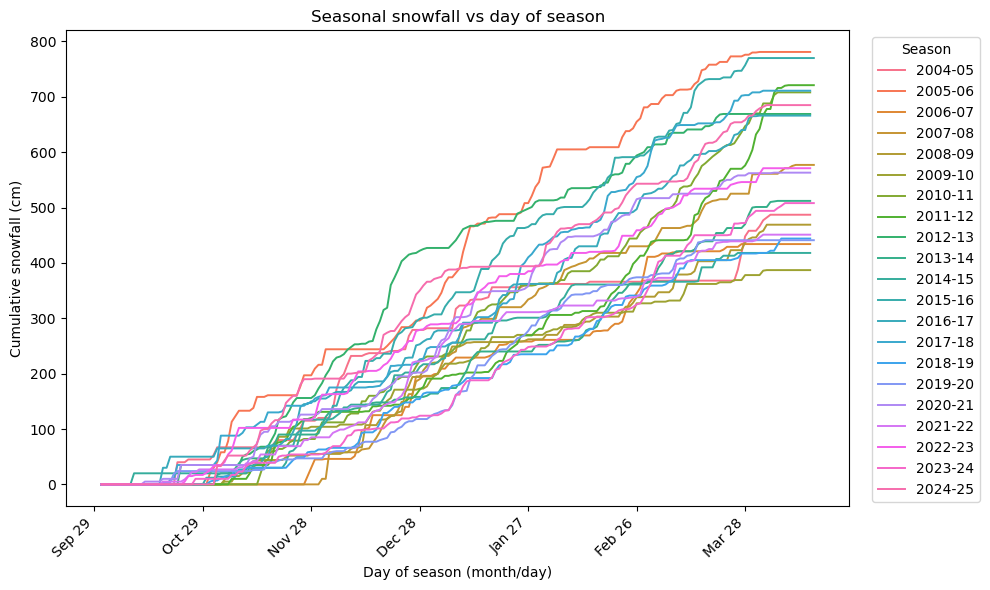

In [103]:
SEASON_START_MONTH = 8
SEASON_START_DAY = 1
SEASON_END_MONTH = 4
SEASON_END_DAY = 15  # adjust as needed

snow_daily = long.dropna(subset=["snow_cm"]).copy()
snow_daily["snow_cm"] = pd.to_numeric(snow_daily["snow_cm"], errors="coerce")
snow_daily = snow_daily.dropna(subset=["snow_cm"])

# Real dates
snow_daily["date"] = pd.to_datetime(
    dict(year=snow_daily["year_num"].astype(int),
         month=snow_daily["month_num"].astype(int),
         day=snow_daily["day"].astype(int)),
    errors="coerce",
)
snow_daily = snow_daily.dropna(subset=["date"])

# Season assignment based on start
season_start_year = snow_daily["date"].dt.year - (
    (snow_daily["date"].dt.month < SEASON_START_MONTH) |
    ((snow_daily["date"].dt.month == SEASON_START_MONTH) &
     (snow_daily["date"].dt.day < SEASON_START_DAY))
)
snow_daily["season"] = (
    season_start_year.astype(int).astype(str)
    + "-" + (season_start_year + 1).astype(int).astype(str).str[-2:]
)

# Anchors
snow_daily["season_start_date"] = pd.to_datetime(
    dict(year=season_start_year.astype(int),
         month=SEASON_START_MONTH,
         day=SEASON_START_DAY)
)
snow_daily["season_end_date"] = pd.to_datetime(
    dict(year=(season_start_year + 1).astype(int),
         month=SEASON_END_MONTH,
         day=SEASON_END_DAY)
)

# Day-in-season; drop rows beyond the end date to keep x-range sane
snow_daily["day_of_season"] = (snow_daily["date"] - snow_daily["season_start_date"]).dt.days + 1
season_len = (snow_daily["season_end_date"] - snow_daily["season_start_date"]).dt.days + 1
snow_daily = snow_daily[snow_daily["day_of_season"] <= season_len]

# Cumulative snow
snow_daily = snow_daily.sort_values(["season", "date"])
snow_daily["cum_snow_cm"] = snow_daily.groupby("season")["snow_cm"].cumsum()

# Formatter to turn day_of_season into month/day labels with fewer ticks
season_start_ref = pd.Timestamp(year=2000, month=SEASON_START_MONTH, day=SEASON_START_DAY)
def fmt_day_month(day_num, _pos):
    if np.isnan(day_num) or day_num < 1:
        return ""
    return (season_start_ref + pd.Timedelta(days=int(day_num) - 1)).strftime("%b %d")

plt.figure(figsize=(10, 6))
ax = sns.lineplot(
    data=snow_daily,
    x="day_of_season",
    y="cum_snow_cm",
    hue="season",
    marker=None,
    linewidth=1.4,
)
ax.xaxis.set_major_locator(MaxNLocator(nbins=8, integer=True, prune="both"))  # fewer ticks
ax.xaxis.set_major_formatter(FuncFormatter(fmt_day_month))
plt.setp(ax.get_xticklabels(), rotation=45, ha="right")

plt.xlabel("Day of season (month/day)")
plt.ylabel("Cumulative snowfall (cm)")
plt.title("Seasonal snowfall vs day of season")
plt.legend(title="Season", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()


### Objective 3: Relate snowfall to El Niño-Southern Oscillation (ENSO)
This section fetches the NOAA MEI v2 index, aligns it with the two-month snowfall totals, and explores how ENSO strength relates to precipitation at Red Resort. The goal is to identify whether ENSO phase provides predictive signal for snowfall planning.


In [104]:
# Fetch the NOAA MEI v2 index and restrict to the analysis period
url = "https://psl.noaa.gov/data/correlation/meiv2.data"

try:
    response = requests.get(url)
    response.raise_for_status()
    content = response.text

    # Extract lines that start with a four-digit year
    data_rows = []
    for line in content.splitlines():
        parts = line.split()
        if not parts:
            continue
        if parts[0].isdigit() and len(parts[0]) == 4:
            data_rows.append(parts)

    cols = ["Year", "DJ", "JF", "FM", "MA", "AM", "MJ", "JJ", "JA", "AS", "SO", "ON", "ND"]
    df = pd.DataFrame(data_rows, columns=cols)

    for c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

    df_filtered = df[(df["Year"] >= 2004) & (df["Year"] <= 2025)]

    print("Shape of filtered data:", df_filtered.shape)
    print(df_filtered.head(25))

except Exception as e:
    print(f"An error occurred: {e}")


Shape of filtered data: (22, 13)
    Year    DJ    JF    FM    MA    AM    MJ    JJ    JA    AS    SO    ON  \
26  2004  0.19 -0.04 -0.43 -0.23 -0.46 -0.38  0.46  0.76  0.58  0.40  0.56   
27  2005  0.09  0.61  0.83  0.14  0.19  0.21 -0.00  0.02 -0.02 -0.66 -0.70   
28  2006 -0.64 -0.49 -0.62 -0.84 -0.42 -0.17  0.22  0.59  0.65  0.77  1.00   
29  2007  0.64  0.40 -0.19 -0.32 -0.41 -0.83 -0.76 -0.91 -1.06 -1.13 -1.12   
30  2008 -1.07 -1.27 -1.52 -1.10 -0.99 -0.79 -0.78 -1.01 -1.02 -1.09 -0.98   
31  2009 -1.01 -0.85 -0.95 -0.81 -0.72 -0.05  0.56  0.56  0.42  0.56  1.04   
32  2010  0.93  1.28  1.33  0.49 -0.12 -1.29 -2.42 -2.38 -2.26 -2.16 -2.01   
33  2011 -1.77 -1.59 -1.75 -1.69 -1.24 -1.03 -0.75 -0.81 -1.08 -1.30 -1.14   
34  2012 -1.07 -0.68 -0.59 -0.38 -0.32 -0.28  0.34 -0.02 -0.29 -0.19 -0.03   
35  2013 -0.06 -0.08 -0.13 -0.35 -0.68 -1.14 -0.79 -0.45 -0.33 -0.13 -0.16   
36  2014 -0.50 -0.42 -0.05 -0.17 -0.17  0.00  0.41  0.23 -0.10  0.11  0.37   
37  2015  0.23  0.06  0.15  0.3

   bimonth_year bimonth total_snow_cm   mei
0          2004      ND          75.0  0.48
1          2004      ON          45.0  0.56
2          2005      AM          29.0  0.19
3          2005      DJ         162.0  0.09
4          2005      FM           6.0  0.83


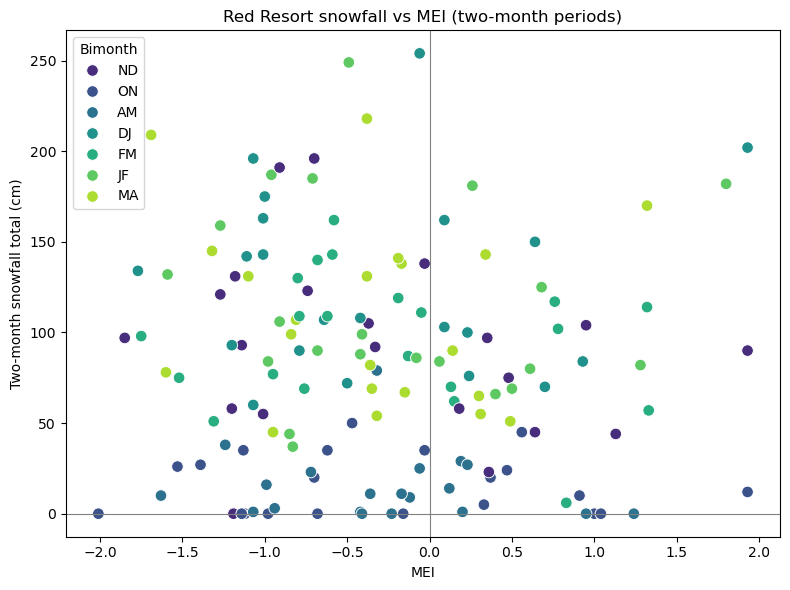

In [105]:
# Align snowfall with MEI by two-month windows

# Map each month to the MEI bimonth code
bimonth_map = {1:"JF", 2:"FM", 3:"MA", 4:"AM", 5:"MJ", 6:"JJ",
               7:"JA", 8:"AS", 9:"SO", 10:"ON", 11:"ND", 12:"DJ"}

def assign_bimonth(row):
    m = int(row["month_num"])
    y = int(row["year_num"])
    label = bimonth_map[m]
    # Align Dec/Jan to the January year so it matches the MEI table
    if m == 12:
        y += 1
    return pd.Series({"bimonth": label, "bimonth_year": y})

snow_daily = long.dropna(subset=["snow_cm"]).copy()
snow_daily[["bimonth", "bimonth_year"]] = snow_daily.apply(assign_bimonth, axis=1)

snow_2mo = (
    snow_daily.groupby(["bimonth_year", "bimonth"], as_index=False)
              .agg(total_snow_cm=("snow_cm", "sum"))
)

# MEI bimonth values reshaped long, keyed the same way
mei_long = (
    df_filtered.melt(id_vars="Year", var_name="bimonth", value_name="mei")
               .rename(columns={"Year": "bimonth_year"})
)

snow_mei = snow_2mo.merge(mei_long, on=["bimonth_year", "bimonth"], how="inner")
print(snow_mei.head())

plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=snow_mei, x="mei", y="total_snow_cm",
    hue="bimonth", palette="viridis", s=70
)
plt.axhline(0, color="gray", lw=0.8)
plt.axvline(0, color="gray", lw=0.8)
plt.xlabel("MEI")
plt.ylabel("Two-month snowfall total (cm)")
plt.title("Red Resort snowfall vs MEI (two-month periods)")
plt.legend(title="Bimonth")
plt.tight_layout()
plt.show()


**ENSO insight:** The scatterplot pairs two-month snowfall totals with the Multivariate ENSO Index (MEI). Points span multiple bimonths to show that, while clustering exists near neutral conditions, there is no strong linear relationship evident without further modelling.
